In [10]:
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.layers import LSTM
from keras.models import Sequential, load_model
# from pyswarm import pso
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import CSVLogger, ReduceLROnPlateau
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense, Activation, Conv1D, MaxPooling1D, Flatten, Reshape,Bidirectional,Input
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM
from keras.models import Sequential, load_model
from keras.callbacks import CSVLogger, ReduceLROnPlateau
import time  # 引入time模块
from keras.layers import Flatten

In [11]:
import warnings
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import warnings
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [12]:
import numpy as np
import pandas as pd

def hav(theta):
    s = np.sin(theta / 2)
    return s * s

def get_distance_hav(lat0, lng0, lat1, lng1):
    EARTH_RADIUS = 6371
    lat0 = np.radians(lat0)
    lat1 = np.radians(lat1)
    lng0 = np.radians(lng0)
    lng1 = np.radians(lng1)

    dlng = np.fabs(lng0 - lng1)
    dlat = np.fabs(lat0 - lat1)
    h = hav(dlat) + np.cos(lat0) * np.cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(h))
    return distance


def createSequence(data, window, maxmin=None):
    train_seq = []
    train_label = []
    m, n = maxmin
    for traj_id in set(data['MMSI']):
        data_temp = data.loc[data['MMSI'] == traj_id]
        first_lon = data_temp.loc[data_temp.index[0], 'Lon']
        first_lat = data_temp.loc[data_temp.index[0], 'Lat']
        end_lon = data_temp.loc[data_temp.index[-1], 'Lon']
        end_lat = data_temp.loc[data_temp.index[-1], 'Lat']

        data_temp = np.array(data_temp.loc[:, ['Lon', 'Lat', 'SOG', 'COG']])
        # 标准化
        data_temp = (data_temp - n) / (m - n)

        for i in range(data_temp.shape[0] - window):
            x = []
            for j in range(i, i + window):
                x.append(list(data_temp[j, :]))
            train_seq.append(x)
            train_label.append(data_temp[i + window, :])

    train_seq = np.array(train_seq, dtype='float64')
    train_label = np.array(train_label, dtype='float64')

    return train_seq, train_label


# 多维反归一化
def FNormalizeMult(y_pre, y_true, max_min):
    [m1, n1, s1, c1], [m2, n2, s2, c2] = max_min
    y_pre[:, 0] = y_pre[:, 0] * (m1 - m2) + m2
    y_pre[:, 1] = y_pre[:, 1] * (n1 - n2) + n2
    y_pre[:, 2] = y_pre[:, 2] * (s1 - s2) + s2
    y_pre[:, 3] = y_pre[:, 3] * (c1 - c2) + c2
    y_true[:, 0] = y_true[:, 0] * (m1 - m2) + m2
    y_true[:, 1] = y_true[:, 1] * (n1 - n2) + n2
    y_true[:, 2] = y_true[:, 2] * (s1 - s2) + s2
    y_true[:, 3] = y_true[:, 3] * (c1 - c2) + c2

    # 计算距离
    y_pre = np.insert(y_pre, y_pre.shape[1],
                      get_distance_hav(y_true[:, 1], y_true[:, 0], y_pre[:, 1], y_pre[:, 0]), axis=1)

    return y_pre, y_true

In [13]:
def trainModel(train_X, train_Y, test_X, test_Y):
    model = Sequential()
    # 展平输入形状 (window_size, num_features) 变为一维向量
    model.add(Flatten(input_shape=(train_X.shape[1], train_X.shape[2])))
    # 添加全连接层的BP神经网络
    model.add(Dense(128, activation="relu"))  # 第一层全连接层
    model.add(Dropout(0.5))  # Dropout层，防止过拟合
    model.add(Dense(64, activation="relu"))   # 第二层全连接层
    model.add(Dropout(0.5))  # Dropout层
    model.add(Dense(train_Y.shape[1]))  # 输出层，输出维度与标签维度相同
    model.add(Activation("relu"))  # ReLU激活函数

    # 使用Adam优化器
    adam = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=adam, metrics=['acc'])  # 使用均方误差（MSE）作为损失函数

    # 记录训练日志
    log = CSVLogger(f"./log.csv", separator=",", append=True)

    # 开始训练模型
    model.fit(train_X, train_Y, epochs=200, batch_size=64, verbose=1, validation_split=0.1, callbacks=[log])

    # 模型评估
    loss, acc = model.evaluate(test_X, test_Y, verbose=1)
    print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))

    # 保存模型
    model.save(f"./bp_model.h5")

    # 打印模型结构
    model.summary()

    return model

In [14]:
# 获取数据
train = pd.read_csv("./train.csv",index_col=0)
test = pd.read_csv("./test.csv",index_col=0)

In [15]:
# 计算归一化参数
nor = np.array(train.loc[:, ['Lon', 'Lat', 'SOG', 'COG']])

m = nor.max(axis=0)
n = nor.min(axis=0)
maxmin = [m, n]
# 步长
windows = 20
train_seq, train_label = createSequence(train, windows, maxmin)
test_seq, test_label = createSequence(test, windows, maxmin)

In [16]:
# 记录整个过程的开始时间
start_time = time.time()

# 训练模型
model = trainModel(train_seq, train_label,test_seq,test_label)

# 记录训练结束时间
end_time = time.time()

total_time = end_time - start_time
print(f"模型训练和评估总耗时: {total_time:.2f} 秒")

Epoch 1/200
2702/2702 [==============================] - 9s 3ms/step - loss: 0.0114 - acc: 0.8380 - val_loss: 0.0032 - val_acc: 0.9517
Epoch 2/200
2702/2702 [==============================] - 8s 3ms/step - loss: 0.0061 - acc: 0.8827 - val_loss: 0.0031 - val_acc: 0.9282
Epoch 3/200
2702/2702 [==============================] - 7s 3ms/step - loss: 0.0055 - acc: 0.8928 - val_loss: 0.0026 - val_acc: 0.9367
Epoch 4/200
2702/2702 [==============================] - 8s 3ms/step - loss: 0.0053 - acc: 0.8942 - val_loss: 0.0029 - val_acc: 0.9424
Epoch 5/200
2702/2702 [==============================] - 8s 3ms/step - loss: 0.0052 - acc: 0.8976 - val_loss: 0.0025 - val_acc: 0.9302
Epoch 6/200
2702/2702 [==============================] - 8s 3ms/step - loss: 0.0051 - acc: 0.9010 - val_loss: 0.0023 - val_acc: 0.9369
Epoch 7/200
2702/2702 [==============================] - 8s 3ms/step - loss: 0.0050 - acc: 0.9009 - val_loss: 0.0022 - val_acc: 0.9487
Epoch 8/200
2702/2702 [==============================] 

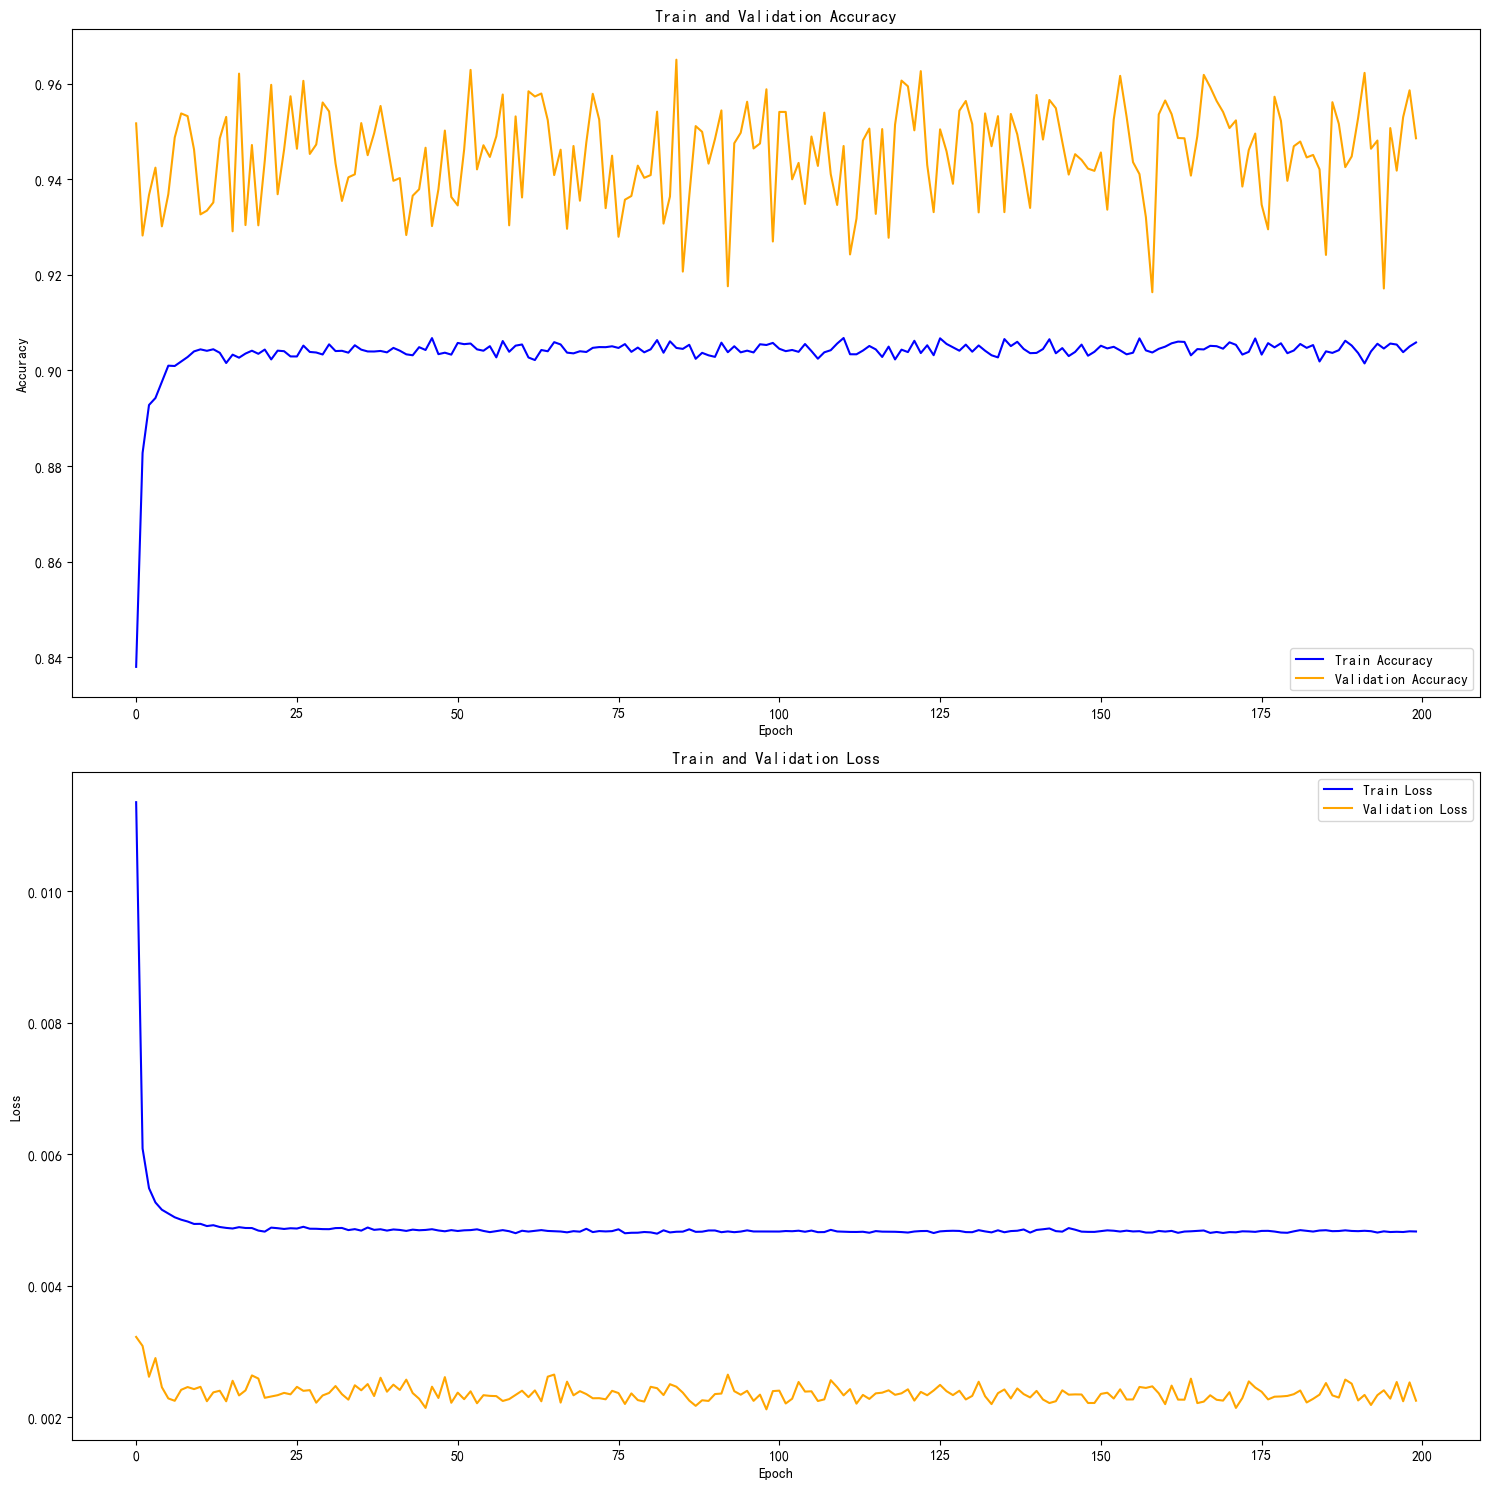

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.read_csv("./logbp.csv")

fig, ax = plt.subplots(2, 1, figsize=(15, 15))

# Plot accuracy
ax[0].plot(logs['epoch'], logs['acc'], label='Train Accuracy', color='blue')
ax[0].plot(logs['epoch'], logs['val_acc'], label='Validation Accuracy', color='orange')
ax[0].set_title('Train and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot loss
ax[1].plot(logs['epoch'], logs['loss'], label='Train Loss', color='blue')
ax[1].plot(logs['epoch'], logs['val_loss'], label='Validation Loss', color='orange')
ax[1].set_title('Train and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


In [17]:
test_points_ids = list(set(test['MMSI']))
BP_error_list = []
BP_Pre0 = []
BP_Pre1 = []
BP_Pre2 = []
BP_Pre3 = []
BP_Tre0 = []
BP_Tre1 = []
BP_Tre2 = []
BP_Tre3 = []
for ids in test_points_ids:
    test_seq, test_label = createSequence(test.loc[test.MMSI == ids], windows, maxmin)
    # 要预测的时间
    pre_time = 10
    # 单值预测
    y_pre_BP_50, y_pre_lstm_50, y_pre_GRU_50, y_pre_biLSTM_50, y_pre_bigru_50, y_pre_CNN_RGRU_Attention_50 = [], [], [], [], [], []
    y_true = []

#     for start_id in range(test_seq.shape[0]-int(pre_time)):
    start_id = 0
    pre_seq = test_seq[start_id]
        # 循环预测
    for i in range(int(pre_time)):
        y_hat_BP_50 =model.predict(pre_seq.reshape(1, windows, 4))
            # 其他模型的预测类似...

        y_pre_BP_50.append(y_hat_BP_50[0])
            # 将其他模型的预测结果也添加到相应的列表中...

        y_true.append(test_label[start_id+i])
        # 下一个数组，把预测的值作为预测序列的最后一个值，实现循环预测
        pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_hat_BP_50, axis=0)[1:]
            
    y_pre_BP_50 = np.array(y_pre_BP_50, dtype='float64')
#         y_pre_lstm_50 = np.array(y_pre_lstm_50, dtype='float64')
#         y_pre_GRU_50 = np.array(y_pre_GRU_50, dtype='float64')
#         y_pre_biLSTM_50 = np.array(y_pre_biLSTM_50, dtype='float64')
#         y_pre_bigru_50 = np.array(y_pre_bigru_50, dtype='float64')
#         y_pre_CNN_RGRU_Attention_50 = np.array(y_pre_CNN_RGRU_Attention_50, dtype='float64')

    y_true = np.array(y_true, dtype='float64')
        # 对预测结果进行归一化处理
    f_y_pre_BP_50, f_y_true = FNormalizeMult(y_pre_BP_50, y_true, maxmin)
        # 对其他模型的预测结果也进行相同的处理
#         f_y_pre_lstm_50, f_y_true = FNormalizeMult(y_pre_lstm_50, y_true, maxmin)
#         f_y_pre_GRU_50, f_y_true = FNormalizeMult(y_pre_GRU_50, y_true, maxmin)
#         f_y_pre_biLSTM_50, f_y_true = FNormalizeMult(y_pre_biLSTM_50, y_true, maxmin)
#         f_y_pre_bigru_50, f_y_true = FNormalizeMult(y_pre_bigru_50, y_true, maxmin)
#         f_y_pre_CNN_RGRU_Attention_50, f_y_true = FNormalizeMult(y_pre_CNN_RGRU_Attention_50, y_true, maxmin)


    BP_Pre0.append(list(np.array(f_y_pre_BP_50)[:, 0]))
    BP_Pre1.append(list(np.array(f_y_pre_BP_50)[:, 1]))
    BP_Pre2.append(list(np.array(f_y_pre_BP_50)[:, 2]))
    BP_Pre3.append(list(np.array(f_y_pre_BP_50)[:, 3]))
    BP_Tre0.append(list(np.array(f_y_true)[:, 0]))
    BP_Tre1.append(list(np.array(f_y_true)[:, 1]))
    BP_Tre2.append(list(np.array(f_y_true)[:, 2]))
    BP_Tre3.append(list(np.array(f_y_true)[:, 3]))
    # 将结果添加到错误列表中
#     BP_error_list.append(list(np.array(y_pre_BP_50)[:, 4]))
    # 将其他模型的结果也添加到相应的列表中...


1/1 [==============================] - 0s 43ms/step


In [18]:
BPP0_data = [item for sublist in BP_Pre0 for item in sublist]
# print(BPP0_data)
BPP1_data = [item for sublist in BP_Pre1 for item in sublist]
# print(BPP1_data)
BPP2_data = [item for sublist in BP_Pre2 for item in sublist]
# print(BPP2_data)
BPP3_data = [item for sublist in BP_Pre3 for item in sublist]
# print(BPP3_data)
BPT0_data = [item for sublist in BP_Tre0 for item in sublist]
# print(BPT0_data)
BPT1_data = [item for sublist in BP_Tre1 for item in sublist]
# print(BPT1_data)
BPT2_data = [item for sublist in BP_Tre2 for item in sublist]
# print(BPT2_data)
BPT3_data = [item for sublist in BP_Tre3 for item in sublist]
# print(BPT3_data)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(BPT0_data, BPP0_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT0_data, BPP0_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT0_data, BPP0_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")
mae = mean_absolute_error(BPT1_data, BPP1_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT1_data, BPP1_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT1_data, BPP1_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")
mae = mean_absolute_error(BPT2_data, BPP2_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT2_data, BPP2_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT2_data, BPP2_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")
mae = mean_absolute_error(BPT3_data, BPP3_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT3_data, BPP3_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT3_data, BPP3_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")

平均绝对误差（MAE）: 0.174202742010579
均方根误差（MSE）: 0.05252586955257611
均方根误差（RMSE）: 0.22918522978712244
R2分数（R2_score）: 0.9351512262863472
--------------------------------------------------
平均绝对误差（MAE）: 0.2221094760743573
均方根误差（MSE）: 0.08298269964957321
均方根误差（RMSE）: 0.2880671790565062
R2分数（R2_score）: 0.8919378531952797
--------------------------------------------------
平均绝对误差（MAE）: 1.447059467917039
均方根误差（MSE）: 4.550966036595635
均方根误差（RMSE）: 2.1332993312227972
R2分数（R2_score）: 0.2812603490934307
--------------------------------------------------
平均绝对误差（MAE）: 32.02044418673648
均方根误差（MSE）: 2805.685514604791
均方根误差（RMSE）: 52.968722040509824
R2分数（R2_score）: 0.72167214343831
--------------------------------------------------
